# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, H. Janati, M. Massias

## Aim

The aim of this material is to code
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 22nd of november at noon**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "ralph"
ln1 = "mouawad"
fn2 = "charles"
ln2 = "karrer"

filename = (
    "_".join(map(lambda s: s.strip().lower(), ["lab3", ln1, fn1, "and", ln2, fn2]))
    + ".ipynb"
)
print(filename)

lab3_mouawad_ralph_and_karrer_charles.ipynb


In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [3]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

/tmp/ipython-input-428856815.py:4: DeprecationWarning: Please import `toeplitz` from the `scipy.linalg` namespace; the `scipy.linalg.special_matrices` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.linalg.special_matrices import toeplitz


## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$


<div class="alert alert-success">
    <b>QUESTION 1:</b> We ask you to code
     <ul>
         <li>cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$</li>
         <li>greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.
</li>
    </ul>
</div>

**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [4]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [5]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []

    w = np.zeros(n_features)
    residuals = b - A.dot(w)

    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO

    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]
        w[j] += A[:, j].dot(residuals) / lips_const[j] ## res is - (Aw-b) this is why we used += not -=
        # update residuals:
        residuals -= A[:, j] * (w[j]-old_w_j)
        # END TODO

        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []

    w = np.zeros(n_features)

    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date

    # TODO
    lips_const = np.linalg.norm(A, axis=0)**2
    # END TODO

    for t in range(n_iter):
        # TODO
        # choose feature j to update:
        j = np.argmax(np.abs(gradient))
        old_w_j = w[j]
        w[j] -= (1/lips_const[j]) * gradient[j]
        # update gradient:
        gradient += gram[:, j] * (w[j] - old_w_j)
        # END TODO
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)

    return w, np.array(all_objs)

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Compute a precise minimum with your favorite solver</li>
         <li>Compare the performance of cyclic and greedy CD as function of iterations.</li>
         <li>From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.</li>
    </ul>
</div>

**Remark:** You will do the plots using the number of iterations on the x-axis and not time as your code is likely to be slow unless you use [numba](https://numba.pydata.org/).

In [6]:
## computing the minimums
w_cyclic, all_objs_cyclic = cyclic_cd(A, b, n_iter=1000)
w_greedy, all_objs_greedy = greedy_cd(A, b, n_iter=1000)

In [7]:
print('CYclic min:', all_objs_cyclic[-1])
print('Greedy min:', all_objs_greedy[-1])

CYclic min: 466.821491048199
Greedy min: 466.39263263504773


The 2 minimums are very similar, with Greedy having a very slightly smaller one.

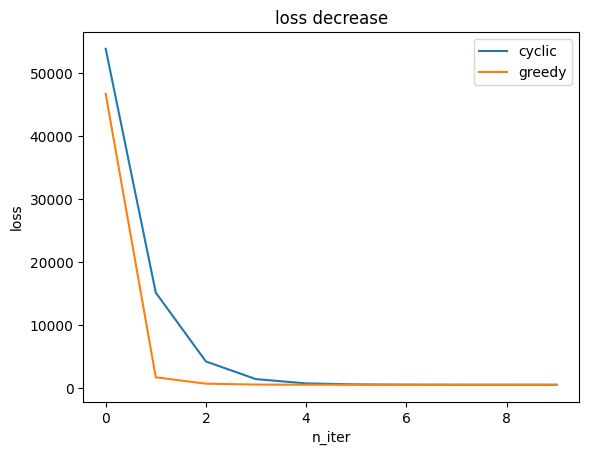

In [8]:
## Loss decrease wrt n_iter
plt.plot(all_objs_cyclic, label='cyclic')
plt.plot(all_objs_greedy, label='greedy')
plt.legend()
plt.title('loss decrease')
plt.xlabel('n_iter')
plt.ylabel('loss')
plt.show()

We can see that Greedy Coordinate Descent converges much faster than cyclic CD. The reason is that at every iteration we're updating the coordinate that is the farest from optimality.

From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.


- Yes we can use it because L2 logistic regression is convex and differentiable everywhere. So we can use Greedy CD in that case.

- Greedy CD, at each iteration, computes the whole gradient to identify which feature to update. If we have 100,000 features, we'll need a lot of time to compute the full gradient. Another thing to add is that 100,000 features mean that every feature will have to get updated alone and each will require many steps. So the algorithm may be very slow. Cyclic CD can however be a bit better in terms of computational complexity.

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$

<div class="alert alert-success">
    <b>QUESTION 3:</b><br/>
    Assuming uniqueness of the solution, show that: $\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.
</div>

**HINT:** You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$
\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert (w_j) =
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0,
         \\ & [-1, 1] &\mathrm{otherwise.}
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

the proble is composed by one smooth and differentiable function 'f', and another non-smooth function 'g' (the L1 norm).

w* = argmin f(w) + $\lambda$ g(w)

$\nabla$F(w) = [$\nabla$f(w), $\nabla$g(w)] = [$\sum_{i}$ -$y_ix_i$(1- $\sigma(y_iw^{T}x_i))$, $\lambda \nabla(||w||_1)$]

Optimality is reached if $\nabla$f(w) + $\lambda \nabla$g(w) = 0.

If w* = 0 then the subdifferential will be equal to $[-1,1]^p$. So $-\nabla$f(w) $\geq$ $\nabla$ g(w).

This means $\lambda$[-1,1]^p $\leq$ $\sum_{i}$ $-y_ix_i$/2

So $\lambda$ $\geq$ 1/2 $||X^Ty||_{∞}$ = $\lambda_{max}$.

If $\lambda$ $\geq$ $\lambda_{max}$ then $\lambda$ $\geq$ 1/2 $||X^Ty||_{∞}$. So $\nabla$f(w) = 1/2 $||X^Ty||_{∞}$ and $\nabla$g(w) = $\lambda$[-1,1]^p which is the fact that w=0

<div class="alert alert-success">
    <b>QUESTION 4:</b><br/>
    Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.
</div>

f(w) = $\sum_i log(1 + \exp(1 + y_iw^Tx_i))$

$\nabla_{w_j} f(w)$ = $\sum_i (-y_ix_{ij}\exp(-y_iw^Tx_i)) / (1 + \exp(-y_iw^Tx_i))$

$Hessian_{w_j} f(w)$ = $\sum_i$ $x_{ij}^2 exp(-y_iw^Tx_i)$ / (1+$exp(-y_iw^Tx_i$))^2

Using th upper bound from lecture notes:

$exp(-z)/(1+exp(-z))^2$ $\leq$ 1/4

We obtain that:

$Hessian_{w_j}$ $\leq$ 1/4 $\sum_i x_{ij}^2$ = 1/4 $||X_{j}||^2$

The Hessian of the non-smooth part is equal to zero so we can say that:

$\gamma_j$ = 1/4$||X_j||^2$


<div class="alert alert-success">
    <b>QUESTION 5:</b><br/>
    Code cyclic proximal coordinate descent for sparse Logistic regression:
</div>

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [9]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.
# much easier to parametrize lambda as a function of lambda_max than
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    all_objs = np.zeros(n_iter)
    w = np.zeros(n_features)
    Xw = X.dot(w)

    # TODO
    lips_const = 1/4 * np.linalg.norm(X, axis=0) ** 2
    # END TODO

    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j = - np.sum(y*X[:,j]*(1-sigmoid(y* Xw)))
            w[j] = soft_thresh(old_w_j - grad_j * 1/lips_const[j], lamb * 1/lips_const[j])

            if old_w_j != w[j]:
                Xw += X[:,j].dot(w[j] - old_w_j)
            #END TODO

        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)

    return w, all_objs

In [10]:
w_log, all_objs_log = cd_logreg(X, y, lamb, n_iter=1000)

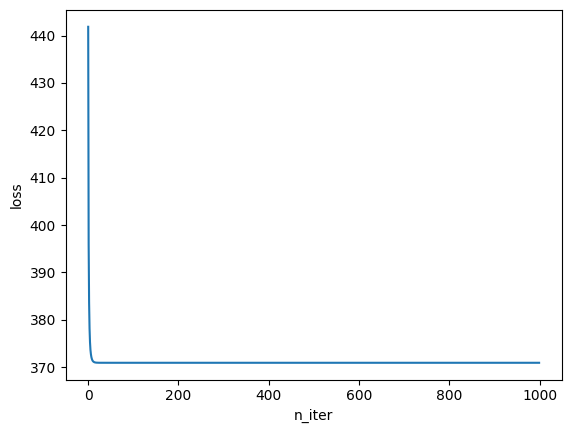

In [11]:
plt.plot(all_objs_log)
plt.xlabel('n_iter')
plt.ylabel('loss')
plt.show()

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [51]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia", version=1)

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

In [52]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

(72, 7129)


Proximal GD

In [53]:
n_samples = X.shape[0]

In [34]:
def smoothness_const_loreg(A):
    """Lipschitz constant for logistic loss"""
    return np.linalg.norm(A.T @ A, 2)
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    return np.sign(x) * np.maximum(np.abs(x)-lmbd, 0) # TODO

def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd*np.linalg.norm(x, 1) # TODO

def loss_logreg(X, y, x):
    """Logistic loss"""
    loss= 0
    for i in range(n_samples):
      loss += np.log(1 + np.exp(-y[i] * (X[i,:].T @ x)))
    return loss

def grad_logreg(X, y, x):
    """Logistic gradient"""
    # grad=np.zeros_like(x)
    grad=0
    for i in range(n_samples):
      b_i = y[i]
      a_i = X[i,:]
      grad += (b_i * a_i) / (1 + np.exp(b_i * (a_i.T @ x)))
    return -grad

In [35]:
def PGD(X, y, x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50, x_true=None, verbose=False):
    x = x0.copy()
    x_new = x0.copy()
    objectives = []

    obj = f(X, y, x) + R(x, lmbd)
    objectives.append(obj)

    if verbose:
        print("Launching PGD...")
        print(' | '.join([name.center(8) for name in ['it', 'obj']]))

    for k in range(n_iter+1):

        # PGD step
        x_new = prox_R(x - step * grad_f(X, y, x), lmbd*step)
        x=x_new
        obj = f(X, y, x) + R(x, lmbd)
        objectives.append(obj)

        if k % 10 == 0 and verbose:
            output = [("%d" % k).rjust(8), ("%.2e" % obj).rjust(8)]
            print(' | '.join(output))

    return x, objectives


In [36]:
step = 1/smoothness_const_loreg(X)
x0 = np.zeros(X.shape[1])
n_iter = 1000

x_pgd, objs_pgd = PGD(
    X, y, x0,
    loss_logreg,
    grad_logreg,
    L1_norm,      # penalty
    prox_L1,      # prox operator
    step,
    lambd,
    n_iter,
    verbose=False
)

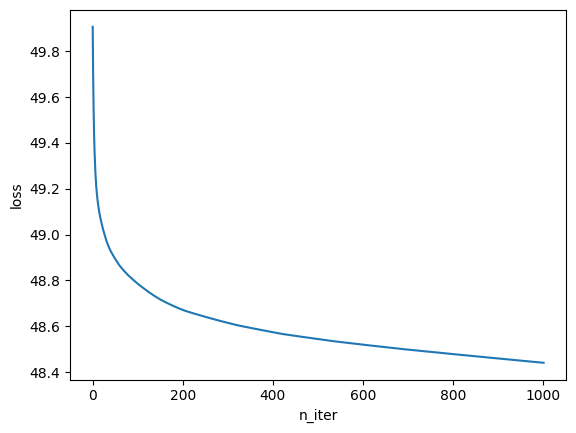

In [37]:
plt.plot(objs_pgd, label='CD')
plt.xlabel('n_iter')
plt.ylabel('loss')
plt.show()

Proximal CD

In [54]:
def smoothness_const_loreg(X):
    return 0.25 * np.sum(X**2, axis=0)

def loss_logreg(X, y, x):
    """Logistic loss"""
    loss= 0
    for i in range(n_samples):
      loss += np.log(1 + np.exp(-y[i] * (X[i,:].T @ x)))
    return loss

def grad_j_logreg(Xj, Xw, y):
    p = 1 / (1 + np.exp(y * Xw))    # σ(-y z)
    grad_j = - (Xj * y * p).sum()
    return grad_j

In [58]:
def PCD(X, y, f, gradj, R, prox_R, step, lmbd, n_iter, verbose=False):

  n_samples, n_features=X.shape
  w=np.zeros(n_features)
  Xw=X.dot(w)

  objectives=[]

  obj = f(X, y, w) + R(w, lmbd)
  objectives.append(obj)

  if verbose:
    print('Launching PCD solver')
    print(' | '.join([name.center(8) for name in ['it', 'obj']]))

  for t in range(n_iter):
    for j in range(n_features):

      old_w_j=w[j]
      grad_j= gradj(X[:,j], Xw, y)
      w[j]=prox_R(w[j] - step[j]*grad_j, lmbd*step[j])

      if old_w_j != w[j]:
        Xw += X[:,j].dot(w[j] - old_w_j)
    obj = f(X, y, w) + R(w, lmbd)
    objectives.append(obj)

    if t%10 == 0 and verbose:
      output= [("%d" % t).rjust(8), ("%.2e" % obj).rjust(8)]
      print(' | '.join(output))

  return w, np.array(objectives)

In [59]:
w_PCD, obj_PCD = PCD(
    X, y,
    loss_logreg,
    grad_j_logreg,
    L1_norm,
    prox_L1,
    1/smoothness_const_loreg(X),
    lambd,
    1000,
    verbose=False
)

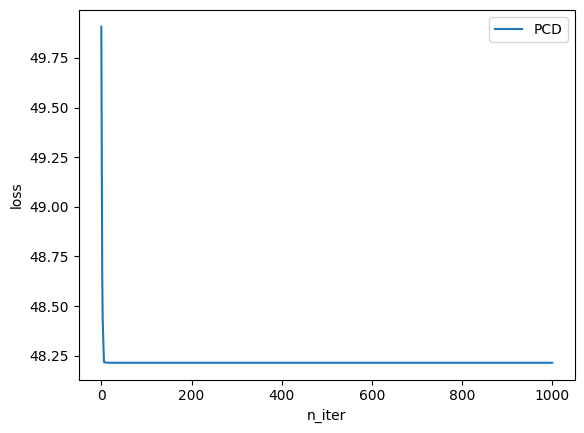

In [60]:
plt.plot(obj_PCD, label='PCD')
plt.xlabel('n_iter')
plt.ylabel('loss')
plt.legend()
plt.show()

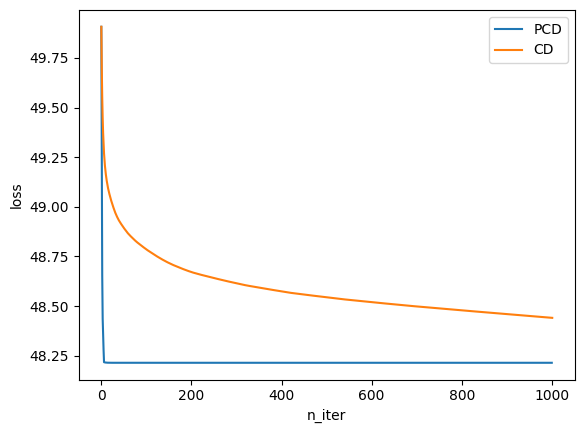

In [61]:
plt.plot(obj_PCD, label='PCD')
plt.plot(objs_pgd, label='PCD')
plt.xlabel('n_iter')
plt.ylabel('loss')
plt.legend()
plt.show()

Conclusion:

We can clearly see that PCD is much faster than PGD. The fact that we are working coordinate-wise in PCD avoids irregular step sizes as every coordinate has its own Lipschitz constant, and this can also promote sparsity for each variable alone. Here we're suffering from underfitting: we have a very small nb of observations which explains why our error is high even at the end of training.

One last thing to note is that PCD might handle better the correlated variables as each is updated separately than the others.